In [1]:
import numpy
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os

In [2]:
folder_bench='results-'
folder_cass='results-cassandra'
#default
experiment_date='2019-10-11T160614'
#large baggage
#experiment_date='2019-10-02T151015'
files = []

In [3]:
folder=folder_bench+experiment_date
with os.scandir(folder) as it:
    for file in it:
        if file.name.endswith('.csv') & file.is_file():
            files.append(folder+'/'+file.name)

In [4]:
data = pd.concat([pd.read_csv(f) for f in files])
traces = pd.read_csv(folder_cass+'/'+'traces-'+experiment_date+'.csv')

In [45]:
dft = pd.DataFrame(traces)
df = pd.DataFrame(data)
if len(df) != len(dft):
    print("Length of datasets is different!!")
df_merged = pd.merge(dft, df, how='outer', left_on=['trace_id', 'span_id'], right_on=['TraceID','SpanID'], copy=False)
df_merged.head(5)

,trace_id,span_id,span_hash,duration,flags,logs,operation_name,parent_id,process,refs,...,tags,write_time,Service,TraceNumber,SpanNumber,TraceID,SpanID,StartTime,FinishTime,Sampled
0,0x000000000000000055637b39f6a3452e,455626409358283208,7613396935165389976,22055,1,NaN,svc02-call-0,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,"[{key: 'internal.span.format', value_type: 'st...",1570802780502035,svc02,115,0,0x000000000000000055637b39f6a3452e,455626409358283208,1570802780252569569,1570802780274628569,True
1,0x000000000000000055637b39f6a3452e,534691889664826154,8681517734354594915,5533,1,NaN,svc08-call-0,0,"{service_name: 'svc08', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,"[{key: 'internal.span.format', value_type: 'st...",1570802780475219,svc08,115,0,0x000000000000000055637b39f6a3452e,534691889664826154,1570802780268335882,1570802780273875217,True
2,0x000000000000000055637b39f6a3452e,744112645963037971,-8819892001788885685,22073,1,NaN,svc02-parent,0,"{service_name: 'svc02', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,"[{key: 'H0cnjpRb26q8Y0fYZff1', value_type: 'st...",1570802780502101,svc02,115,-1,0x000000000000000055637b39f6a3452e,744112645963037971,1570802780252558299,1570802780274634619,True
3,0x000000000000000055637b39f6a3452e,1554878844227750586,-3154117628687752418,10778,1,NaN,svc06-parent,0,"{service_name: 'svc06', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,"[{key: 'oft12lgNDlpvXoW8tJDe', value_type: 'st...",1570802780522636,svc06,115,-1,0x000000000000000055637b39f6a3452e,1554878844227750586,1570802780263344151,1570802780274126854,True
4,0x000000000000000055637b39f6a3452e,2175919761560721763,3494468924600610143,2836,1,NaN,svc09-call-0,0,"{service_name: 'svc09', tags: [{key: 'jaeger.v...","[{ref_type: 'child-of', trace_id: 0x0000000000...",...,"[{key: 'internal.span.format', value_type: 'st...",1570802780491048,svc09,115,0,0x000000000000000055637b39f6a3452e,2175919761560721763,1570802780270910567,1570802780273757348,True


In [46]:
df_merged['SpanDuration'] = df_merged['FinishTime'] - df_merged['StartTime']
df_merged.StartTime = df_merged.StartTime / 1000.0
df_merged.FinishTime = df_merged.FinishTime / 1000.0
df_merged.SpanDuration = df_merged.SpanDuration / 1000.0
df_merged = df_merged.astype({'StartTime': 'int64', 'FinishTime': 'int64', 'SpanDuration': 'int64'})
#Filter non-sampled span data
df_merged = df_merged.loc[df_merged['Sampled']]
df_merged = df_merged.sort_values(by = ['trace_id', 'StartTime'])
df_merged.reset_index(drop=True, inplace=True)
len(df_merged)

22800

## Assumptions for Calculations
Assumptions necessary for calculation of trace completion times, i.e. the point in time a all Spans of a trace have been written to a database.
1. All Traces are completed, i.e. all Spans part of a Trace are in the dataset
1. All Traces are sorted by trace id and consist of an equal number of spans

In [52]:
df_merged['span_visibility'] = df_merged.write_time - df_merged.StartTime
starttime = 0
completion_times = [0]*len(df_merged)
firstTraceIdx = 0
lastTraceIdx = 0
write_times_tmp = []
current_trace_id = df_merged['trace_id'].iloc[0]
#init with first trace id
for index, row in df_merged.iterrows():
    if row['trace_id'] == current_trace_id:
        write_times_tmp.append(row['write_time'])
    else:
        lastTraceIdx = index
        trace_completion_time = max(write_times_tmp) - starttime
        write_times_tmp = []
        for i in range(firstTraceIdx, lastTraceIdx):
            completion_times[i] = trace_completion_time
    #use starttime of root span
    if row['operation_name'] == 'svc01-parent':
        starttime = row['StartTime']
        firstTraceIdx = index
        current_trace_id = row['trace_id']
    #save the write time of current span in temp list
df_merged['trace_completion_time'] = completion_times

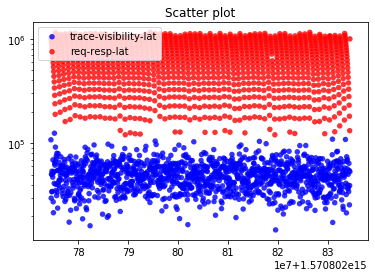

<Figure size 432x288 with 0 Axes>

In [53]:
#df_merged.drop(df_merged.index[:100], inplace=True)
df_roots = df_merged.loc[df_merged['operation_name'] == 'svc01-parent']
df_roots = df_roots.sort_values(by = ['StartTime'])
colors = {'red', 'blue'}
categories = {'req-resp-lat', 'trace-visibility-lat'}
columns = {'duration', 'trace_completion_time'}
scatterplot = plt.figure()
ax = scatterplot.add_subplot(1, 1, 1)
for column, color, cat in zip(columns, colors, categories):
    x, y = df_roots['StartTime'], df_roots[column]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=cat)
plt.title('Scatter plot')
plt.yscale("log")
plt.legend(loc=2)
plt.show()
plt.savefig('shower.pdf')

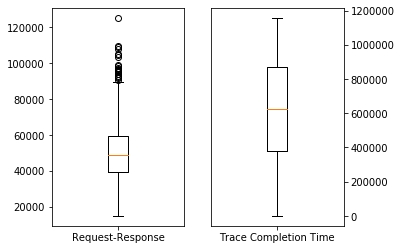

In [54]:
#plt.title('Visibility Delay')
figure1, axes = plt.subplots(1, 2)
#apparently we have too much stuff going on at the righthand y-axis, so we need to add extra space
figure1.subplots_adjust(right=0.8)
#axes[0].text('Latency [µs]')
label = 'exp'
#label = 'large-baggage'
axes[0].boxplot([df_roots['duration']], labels=['Request-Response'])
#plt.savefig('latency-high-baggage.pdf')
axes[1].boxplot([df_roots['trace_completion_time']], labels=['Trace Completion Time'])
axes[1].yaxis.tick_right()
figure1.savefig('latency-'+label+'.pdf')
#plt.savefig('completion-high-baggage.pdf')
#plt.savefig('completion'+label+'.pdf')
#plot = plt.boxplot([df_roots['duration'], df_roots['completion_time']], labels=['Request-Response','Trace Completion'])

In [56]:
df_roots = df_roots[['duration', 'SpanDuration', 'span_visibility', 'trace_completion_time']]
numpy.round(df_roots.describe().T, 2).to_csv('summary-'+label+'.csv', sep=',')